In [101]:
"""
Integrantes: Mariana Saavedra, David Herrera
"""
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import scipy.stats as sc
from tqdm import tqdm
import numpy as np
import csv
def kMeans(D,k,eps,mu=None,max_iterations=500):
    while True:
        t=0
        mu=[]
        for ki in range(k):
            mu.append(np.random.uniform(D.min(0),D.max(0),len(D.min(0))))
        mun=[mu]
    
        for l in range(max_iterations):
            t+=1
            c=[]
            for m in range(k):
               c.append([])
            for j in range(D.shape[0]):
                mini = np.inf
                temp=0
                for i in range(len(mun[t-1])):
                    distancia=np.linalg.norm(D[j]-mun[t-1][i])
                    if distancia<mini:
                        mini=distancia
                        temp=i
                c[temp].append(list(D[j]))
            mu=[]
            for i in range(k):
                sum=np.zeros(len(D[0]))
                for j in c[i]:
                    sum+=np.array(j)
                if len(c[i])!=0:
                    mu.append(list(sum/len(c[i])))
            mun.append(mu)
            
            error=0
            for i in range(len(mun[t])):
                error+=(abs(np.linalg.norm(np.array(mun[-1][i])- np.array(mun[-2][i]))))**2
            if error < eps:
                break
        if min([len(ci) for ci in c])!=0:
            break
    return c,mu
def EM(D, k, eps, mu = None, independent = False,max_iterations=500):
    n,p=D.shape
    t=0
    cov=[]
    pis=[]
    if not mu:
        mu=[]
        for ki in range(k):
            mu.append(np.random.uniform(D.min(0),D.max(0),p))

    covas=[]
    for ki in range(k):
        sum=np.zeros((p, p))
        for j in range(n):
            ys = np.reshape(D[j]- mu[ki], (p,1))
            sum += np.dot(ys, ys.T)
        covas.append(sum)
    for ki in range(k):
        cov.append((covas[ki])/n)#np.identity(p))
        pis.append(1/k)
    mut=[mu]
    for l in range(max_iterations):
        t+=1
        w = np.zeros((k, n))
        #Expectation Step
        for i in range(k):
            for j in range(n):
                w[i, j] = sc.multivariate_normal(mut[t-1][i], cov[i]).pdf(D[j]) *pis[i]
        w = w/w.sum(0)
        #check sum 1
        # print("---",w.sum(0))
            
        #maximization Step
        
        # mu
        mu = np.zeros((k, p))
        for i in range(k):
            for j in range(n):
                mu[i] += w[i, j] * D[j]
            mu[i] /= w[i, :].sum()
        mut.append(mu)
        
        # covariance
        if independent:
            cov = np.zeros((k,  p, p))
            for i in range(k):
                for j in range(n):
                    ys = np.zeros((p, p))
                    np.fill_diagonal(ys, (D[j]- mu[i])**2)
                    cov[i] += w[i,j] * ys
                cov[i] /= w[i,:].sum()
        else:
            cov = np.zeros((k,  p, p))
            for i in range(k):
                for j in range(n):
                    ys = np.reshape(D[j]- mu[i], (p,1))
                    cov[i] += w[i,j] * np.dot(ys, ys.T)
                cov[i] /= w[i,:].sum()
        # pi
        pis = np.zeros(k)
        for j in range(k):
            for i in range(n):
                pis[j] += w[j, i]
        pis /= n
        
        error=0
        for i in range(len(mut[t])):
            error+=(abs(np.linalg.norm(np.array(mut[-1][i])- np.array(mut[-2][i]))))**2
        if error < eps:
            break
    return w, mu, cov
def agglomerativeClustering3(D, dist, k=1):
    total=[]
    C=[]
    for point in D:C.append([point])
    tri=triangulo(C)
    total.append(C)
    while len(C)!=k and k<=len(C):
        Ci,Cj=np.unravel_index(np.argmin(tri,axis=None),tri.shape)
        
        lan=lanceWilliams(Ci,Cj,len(C),tri,C,dist=dist)
        C[Ci]=C[Ci]+C[Cj]
        C.remove(C[Cj])
        
        tri=np.delete(tri,Cj,1)
        tri=np.delete(tri,Cj,0)
        tri[Ci]=lan
        tri[:,Ci]=lan
        total.append(C)
    return total
def triangulo(D):
    n=len(D)
    arr=np.empty([n,n])
    for i in range(n):
        for j in range(n):
            if j!=i:
                if j>i:
                    arr[j][i]=arr[i][j]=distEucl(D[i],D[j])
            else:
                arr[i][j]=np.Inf
    return  arr
def lanceWilliams(i,j,Cr,matri,C,alphai=None,alphaj=None,beta=None,gama=None,dist=None):
    if type(dist)== str:
        leCi,leCj,leCr=len(C[i]),len(C[j]),Cr-2
        if dist=='single':alphai,alphaj,beta,gama=1/2,1/2,0,-1/2
        if dist=='complete':alphai,alphaj,beta,gama=1/2,1/2,0,1/2
        if dist=='avg':alphai,alphaj,beta,gama=leCi/(leCi+leCj),leCj/(leCi+leCj),0,0
        if dist=='centroid':alphai,alphaj,beta,gama=leCi/(leCi+leCj),leCj/(leCi+leCj),(-leCi*leCj)/(leCi+leCj)**2,0
        if dist=='ward':alphai,alphaj,beta,gama=(leCi+leCr)/(leCi+leCj+leCr),(leCj+leCr)/(leCi+leCj+leCr),(-leCr)/(leCi+leCj+leCr),0
        temp=[]
        for r in range(Cr):
            if r != i:
                if r!=j:
                    res=alphai*matri[i,r]+alphaj*+matri[j,r]+beta*matri[i,j]+gama*abs(matri[i,r]-matri[j,r])
                    temp.append(res)
            else:
                temp.append(np.inf)
    else:
        temp=[]
        for r in range(Cr):
            if r != i:
                if r!=j:
                    res=alphai*matri[i,r]+alphaj*+matri[j,r]+beta*matri[i,j]+gama*abs(matri[i,r]-matri[j,r])
                    temp.append(res)
            else:
                temp.append(np.inf)
    return temp
def readCsv2D(file):
    with open(file) as csv_file:
        delimiter=','
        if file=='spiral.csv':delimiter='\t'
        csv_reader = csv.reader(csv_file, delimiter=delimiter)
        if file=='iris.csv':next(csv_reader, None)
        d=[]
        for row in csv_reader:
            temp=[]
            for i in range(2):temp.append(float(row[i]))
            d.append(temp)
    return  d
def distEucl(a1,a2):
    return np.linalg.norm(np.array(a1)-np.array(a2))
def computeNeighbors(D,x,e):
    neighbors=[]
    for point in D:
        if distEucl(point,x)<=e:
        # if point!=x and distEucl(point,x)<=e:
            neighbors.append(point)
    return neighbors
def densityConnected(xi,k,clusters,core,neighbors):
    for y in neighbors[str(xi)]:
        if not k in clusters[str(y)]:
            clusters[str(y)].append(k)
            if y in core:densityConnected(y,k,clusters,core,neighbors)
def DBSCAN(D,epsilon,minpts):
    Core=[]
    clusters=dict()
    neighbors=dict()
    for xi in tqdm(D):
        Ne=computeNeighbors(D,xi,epsilon)
        clusters[str(xi)]=[]
        neighbors[str(xi)]=Ne
        if len(Ne)>=minpts:Core.append(xi)
    k=0
    for xi in Core:
        if len(clusters[str(xi)])==0:
            k+=1
            clusters[str(xi)].append(k)
            densityConnected(xi,k,clusters,Core,neighbors)
    C=[]
    for i in range(1,k+1):
        ci=[]
        for x in D:
            if i in clusters[str(x)]:ci.append(x)
        C.append(ci)
    Noise=[]
    for x in D:
        if len(clusters[str(x)])==0:
            Noise.append(x)
    Border=[item for item in D if item not in Core+Noise]
    return C,Core,Border,Noise
def discrete(z):
    return 1 if all(abs(dim) <=1/2 for dim in z) else 0
def gaussian(z):
    return (1/np.sqrt(2*np.pi))*np.exp(-(((z)**2)/2))
def FindAttractor(x,D,h,epsilon,K):
    t=0
    xt=[x]
    while True:
        vector=sum([ K(np.subtract(xt[t],xi)/h)*np.array(xt[t]) for xi in D])
        peso=sum([ K(np.subtract(xt[t],xi)/h) for xi in D])
        xt.append(list(vector/peso))
        t+=1
        if distEucl(xt[t],xt[t-1])<=epsilon:break
    return xt[t]
def Denclue(D,h,erara,epsilon,K='discrete'):
    K=eval(K)
    atractores,atraidos=[],{}
    for x in tqdm(D):
        xAs=FindAttractor(x,D,h,epsilon,K)
        suma=sum([K(np.subtract(xAs,xi)/h) for xi in D])
        if suma/(len(D)*h**2)>=erara:
            atractores.append(xAs)
            try:atraidos[str(xAs)].append(x)
            except KeyError:atraidos[str(xAs)]=[x]
            
    faltantes=[atractor for atractor in atractores]
    ClustersAtractores,puntosRevisado=[],[]
    k=0
    while len(faltantes)!=0:
        ClustersAtractores.append([faltantes[0]])
        faltantes.remove(faltantes[0])
        if len(faltantes)!=0:
            alcanzables(D,faltantes[0],faltantes,puntosRevisado,epsilon,k,ClustersAtractores,atractores)
            k+=1
    C=[[[atraido for atraido in atraidos[str(atr)]][0] for atr in c] for c in ClustersAtractores]
    return C
def alcanzables(data,punto,faltantes,puntosRevisado,epsilon,k,ClustersAtractores,atractores):
    vecinos=computeNeighbors(data,punto,epsilon)
    for vecino in vecinos:
        if vecino not in puntosRevisado:
            puntosRevisado.append(vecino)
            for atractor in atractores:
                if atractor in faltantes:
                    if distEucl(vecino,atractor)<=epsilon:
                        faltantes.remove(atractor)
                        ClustersAtractores[k].append(atractor)
            alcanzables(data,vecino,faltantes,puntosRevisado,epsilon,k,ClustersAtractores,atractores)

100%|██████████| 2396/2396 [01:39<00:00, 24.00it/s]


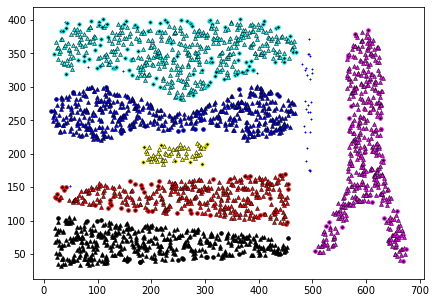

In [102]:
data=readCsv2D("torre.csv")
epsilon=18
minpts=10
C,Core,Border,Noise=DBSCAN(data,epsilon,minpts)
colors=['yellow','blue','black','red','cyan','magenta','yellow','blue','red','cyan','green','magenta']
fig, ax = plt.subplots(figsize=(7,5))
for point in Noise:ax.plot(point[0],point[1],c='b',marker='+',ms=2)
for i,c in enumerate(C):
    for point in c:
        if point in Border:
            ax.plot(point[0],point[1],c='k',marker='.',ms=7,mec=colors[i],mew=1)
        if point in Core:
            ax.plot(point[0],point[1],c=colors[i],marker='^',ms=4,mec='k',mew=0.5)
plt.show()

100%|██████████| 5000/5000 [06:50<00:00, 12.18it/s]


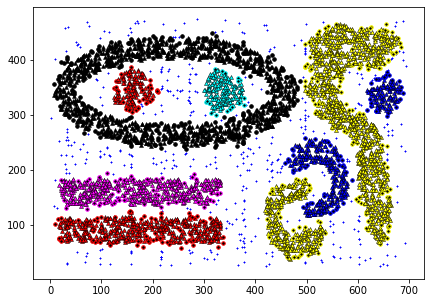

In [103]:
data=readCsv2D("libroSmall.csv")
epsilon=12
minpts=10
C,Core,Border,Noise=DBSCAN(data,epsilon,minpts)
colors=['yellow','blue','black','red','cyan','magenta','yellow','blue','red','cyan','green','magenta']
fig, ax = plt.subplots(figsize=(7,5))
for point in Noise:ax.plot(point[0],point[1],c='b',marker='+',ms=2)
for i,c in enumerate(C):
    for point in c:
        if point in Border:
            ax.plot(point[0],point[1],c='k',marker='.',ms=7,mec=colors[i],mew=1)
        if point in Core:
            ax.plot(point[0],point[1],c=colors[i],marker='^',ms=4,mec='k',mew=0.5)
plt.show()

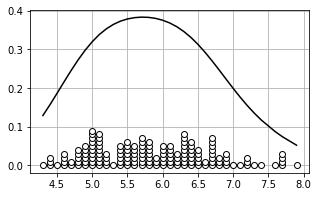

In [104]:
"""prueba"""
data = readCsv2D("iris.csv")
data= np.array(data)[:,0]
data.tolist()
data.sort()
fGorro={}
h=0.5
for point in data:
    valor=sum([gaussian((point-xi)/h) for xi in data])/(len(data)*h)
    try:
        fGorro[str(point)].append(valor)
    except KeyError:
        fGorro[str(point)]=[]
        fGorro[str(point)].append(valor)
fig, ax = plt.subplots(figsize=(5,3))
x=[]
y=[]
for key in fGorro:
    x.append(float(key))
    y.append(fGorro[key][0])
    for n in range(len(fGorro[key])):
        ax.plot(float(key),0.01*n, 'wo',mec='k')
ax.plot(x,y, 'k-')
ax.grid(True)

kmeans
aglo|single
dbscan
EM
aglo|ward
Denclue


100%|██████████| 312/312 [00:02<00:00, 109.44it/s]


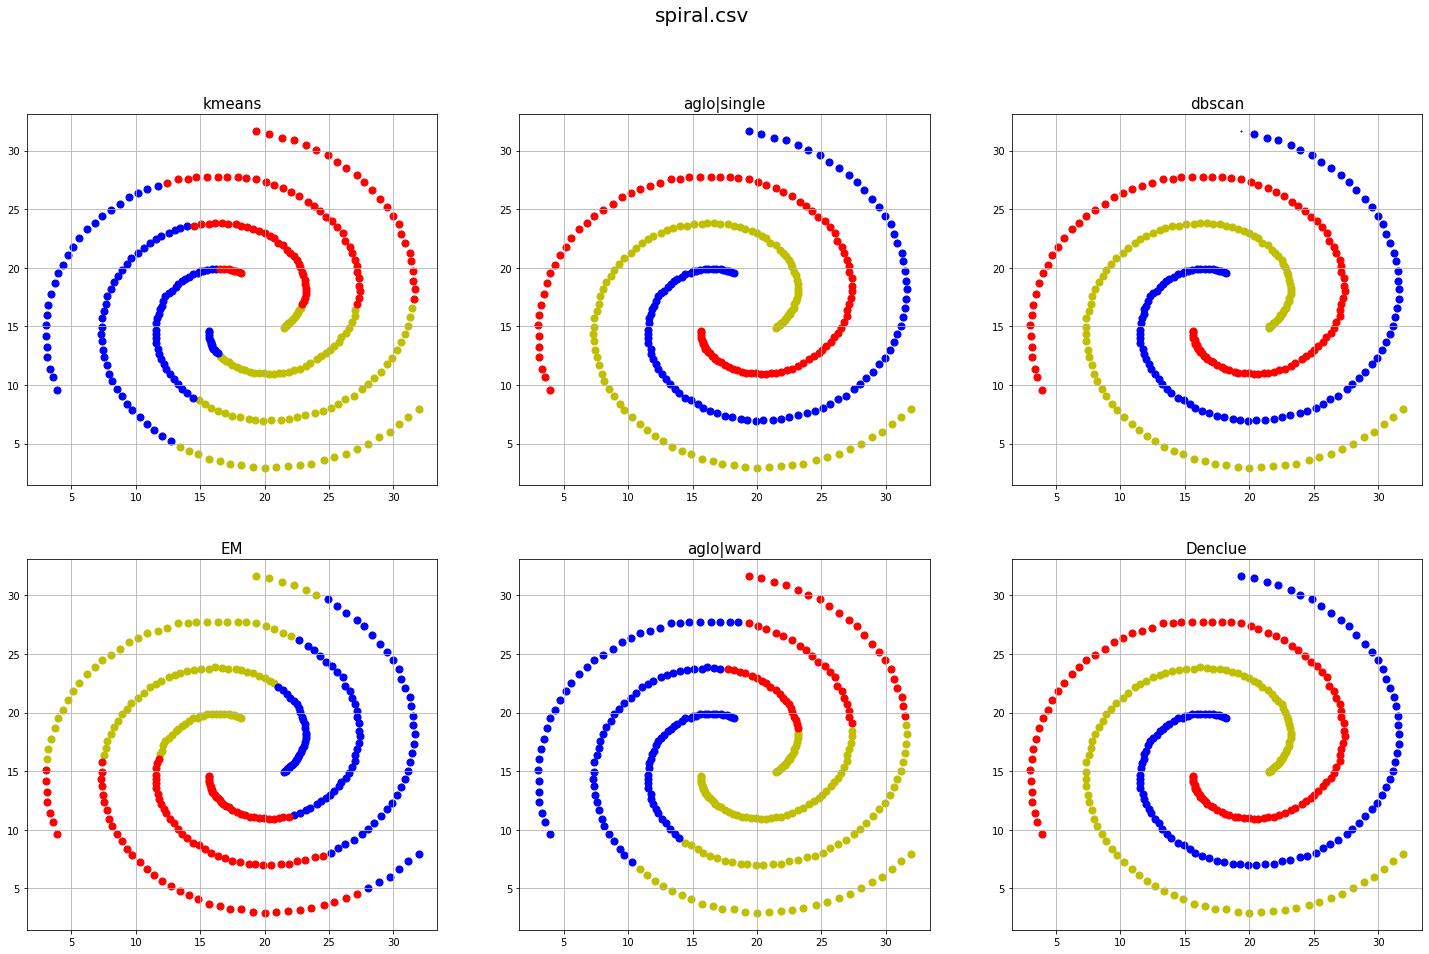

In [105]:
#============================================================2.1
algoritmos=["kmeans","aglo|single","dbscan","EM","aglo|ward","Denclue"]
colors=['y','b','r','g','orange','black','magenta']
data=readCsv2D('spiral.csv')
fig = plt.figure()
fig.suptitle("spiral.csv", fontsize=20)
fig.set_size_inches(25,15)
cont=1
k=3
epsilon=2
minpts=5
for algoritmo in algoritmos:
    print(algoritmo)
    ax =  fig.add_subplot(2, 3, cont)
    cont+=1
    if algoritmo=="kmeans":
        C,mu=kMeans(np.array(data),k,0.001)
    if algoritmo=="EM":
        w, mu, cov=EM(np.array(data),k,0.001,independent=False)
        C=[[] for i in range(k)]
        maximos=np.unravel_index(np.argmax(w,axis=0),w.shape)[1]
        for i in range(len(data)):C[maximos[i]].append(data[i])
    if "aglo" in algoritmo:
        C=agglomerativeClustering3(data,algoritmo.split("|",1)[1] ,k)
        C=C[-1]
    if algoritmo=="dbscan":
        C,Core,Border,Noise=DBSCAN(data,epsilon,minpts)
        for point in Noise:
            ax.plot(point[0],point[1],c='b',marker='+',ms=2)
    if algoritmo=="Denclue":
        C=Denclue(data,1/minpts,minpts*0.01,epsilon)
    xs=[[point[0] for point in cluster] for cluster in C]
    ys=[[point[1] for point in cluster] for cluster in C]
    for i in range(0,len(C)):
        ax.scatter(xs[i], ys[i],c=colors[i],s=50)
    ax.set_title(algoritmo,fontsize=15)
    ax.grid()

100%|██████████| 1000/1000 [00:35<00:00, 28.06it/s]


grupos.csv
	DBSCAN
	Denclue
elipses.csv
	DBSCAN
	Denclue
formas.csv
	DBSCAN
	Denclue
feliz.csv
	DBSCAN
	Denclue


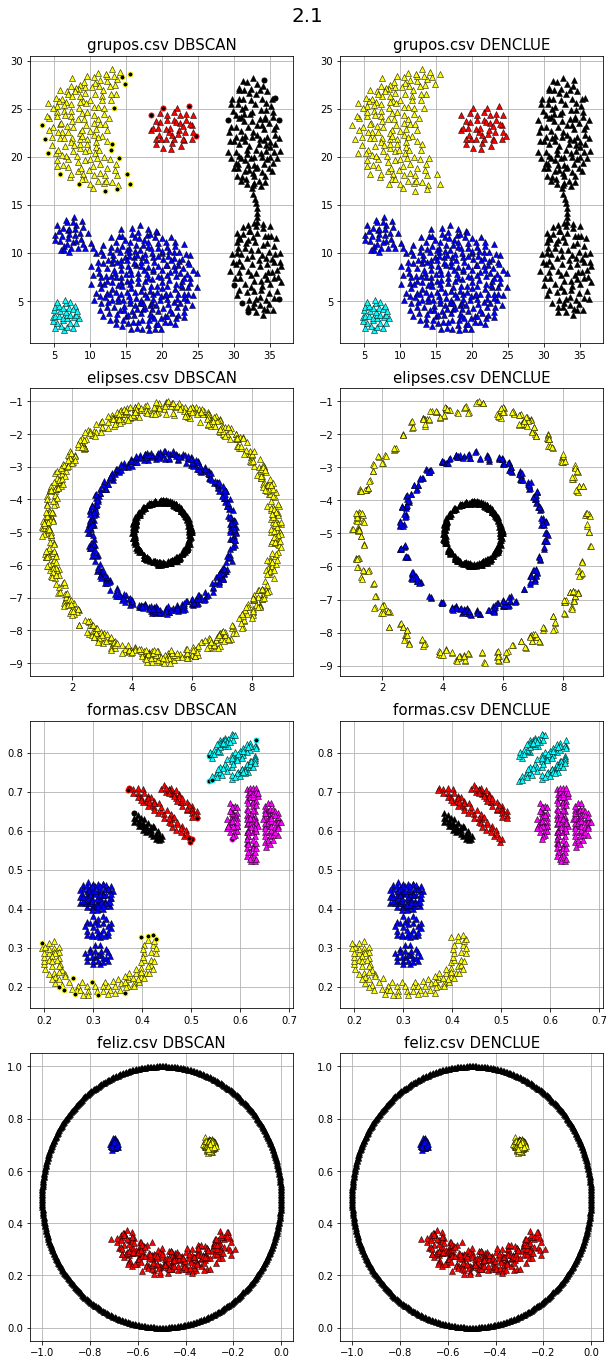

In [106]:
#============================================================2.2
colors=['yellow','blue','black','red','cyan','magenta','yellow','blue','red','cyan','green','magenta']
archivos=["grupos.csv","elipses.csv","formas.csv","feliz.csv"]
fig = plt.figure()
fig.suptitle("2.1", fontsize=20)
fig.set_size_inches(10,20)
cont=1
epsilon=0.04
minpts=7
for archivo in archivos:
    print(archivo)
    data=readCsv2D(archivo)
    if archivo=="grupos.csv":epsilon,minpts=2,10
    if archivo=="grupos.csv":epsilon,minpts=2,10
    if archivo=="elipses.csv":epsilon,minpts=1,10
    if archivo=="feliz.csv":epsilon,minpts=0.1,10
    if archivo=="formas.csv":epsilon,minpts=0.03,10
    print("\tDBSCAN")
    C,Core,Border,Noise=DBSCAN(data,epsilon,minpts)
    ax =  fig.add_subplot(4, 2, cont)
    cont+=1
    for point in Noise:
        ax.plot(point[0],point[1],c='b',marker='+',ms=2)
    for i,c in enumerate(C):
        for point in c:
            if point in Border:
                ax.plot(point[0],point[1],c='k',marker='.',ms=10,mec=colors[i],mew=1)
            if point in Core:
                ax.plot(point[0],point[1],c=colors[i],marker='^',ms=6,mec='k',mew=0.5)
    ax.set_title(archivo+" DBSCAN",fontsize=15)
    ax.grid()
    
    print("\tDenclue")
    C=Denclue(data,1/minpts,minpts*0.01,epsilon)
    ax =  fig.add_subplot(4, 2, cont)
    cont+=1
    for i,c in enumerate(C):
        for point in c:
            ax.plot(point[0],point[1],c=colors[i],marker='^',ms=6,mec='k',mew=0.5)
    ax.set_title(archivo+" DENCLUE",fontsize=15)
    ax.grid()
    plt.tight_layout(pad=6, w_pad=2, h_pad=1)
